# Category Prediction on BBC-news data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from xgboost import XGBClassifier

from helper import plot_history, calc_prediction, process_text

data_dir = './'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import json

with open(data_dir+"label_dict.json", 'r') as fp:
    label_dict = json.load(fp)

with open(data_dir+"label_dict_reversed.json", 'r') as fp:
    label_dict_reversed = json.load(fp)

print (label_dict, label_dict_reversed)
df = pd.read_csv(data_dir+'bbc_text_processed.csv')
print ('data.shape:',df.shape)
df.head(2)

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4} {'0': 'tech', '1': 'business', '2': 'sport', '3': 'entertainment', '4': 'politics'}
data.shape: (2225, 5)


,category,text,label,text_processed,text_len
0,tech,tv future in the hands of viewers with home th...,0,tv futur hand viewer home theatr system plasma...,407
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left book alon former worldcom b...,186


## Bag of Words Method

In [3]:
from collections import Counter
ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)

In [4]:
DICT_SIZE = 1000
VOCAB = words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX = {item[0]:ii for ii, item in enumerate(VOCAB) }
INDEX_TO_WORDS = {ii:word for word, ii in WORDS_TO_INDEX.items()}

In [5]:
from collections import Counter
from scipy import sparse as sp_sparse

ALL_WORDS = [word for text in df['text_processed'] for word in text.split() ]
words_counts = Counter(ALL_WORDS)

def bag_of_words(text, words_to_index):
    result_vec = np.zeros(len(words_to_index.keys()))
    for word in text.split():
        if word in words_to_index:
            result_vec[words_to_index[word]] +=1
    return result_vec

def prepare_BOW(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
    X_train_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                       WORDS_TO_INDEX)) for text in df_train[col]])
    X_test_bow = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(text,
                                                                      WORDS_TO_INDEX)) for text in df_test[col]])

    y_train = df_train['label'].values
    y_test  = df_test['label'].values
    
    print('X_train shape ', X_train_bow.shape)
    print('X_test shape ',  X_test_bow.shape)
    print('y_train shape ', y_train.shape)
    print('y_test shape ',  y_test.shape)
    
    return X_train_bow, X_test_bow, y_train, y_test

X_train_bow, X_test_bow, y_train_bow, y_test_bow = prepare_BOW(df, "text_processed")

X_train shape  (1780, 1000)
X_test shape  (445, 1000)
y_train shape  (1780,)
y_test shape  (445,)


## Model : XGBoost for BOW method

In [6]:
model_xgb = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
model_xgb.fit(X_train_bow, y_train_bow)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

Test set accuracy score: 97.75
Test set f1 score: 97.72 


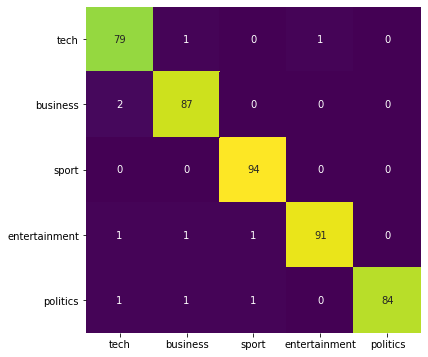

In [7]:
calc_prediction(model_xgb, X_test_bow, y_test_bow, categorical=False, ax=None, title=None)

## Tf-IDF method
- train, test, val split
- tokenize the text
- Use TFIDF features from sklearn

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def prepare_TFIDF(df, col):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)

    """Extract features for given field and using different methods"""
    vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    vectorizer.fit_transform(df_train[col].values)
    
    X_train = vectorizer.transform(df_train[col].values)
    X_test  = vectorizer.transform(df_test[col].values)
    
    y_train = df_train['label'].values
    y_test  = df_test['label'].values

    return X_train, X_test, y_train, y_test, vectorizer

X_train_tf, X_test_tf, y_train_tf, y_test_tf, vectorizer= prepare_TFIDF(df, "text_processed")

## Model : XGBoost for TFIDF method

In [9]:
model_xgb_tf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
model_xgb_tf.fit(X_train_tf, y_train_tf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

Test set accuracy score: 98.20
Test set f1 score: 98.18 


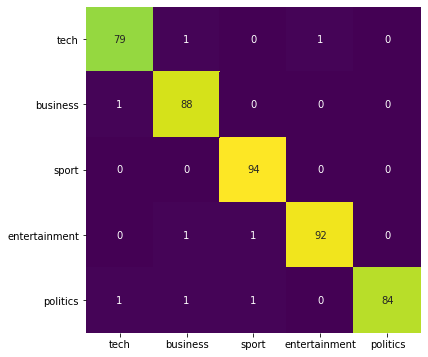

In [10]:
calc_prediction(model_xgb_tf, X_test_tf, y_test_tf, categorical=False, ax=None, title=None)

## Predictions for new texts

In [11]:
def Prediction_tf(doc, model=model_xgb_tf, vectorizer=vectorizer):    
    doc_processed = process_text(doc)
    X_in = vectorizer.transform([doc_processed])
    y_out = model.predict(X_in)[0]
    category = label_dict_reversed[str(y_out)]
    
    print (f"\nTFIDF Prediction \n\n {category}")

In [12]:
def Prediction_bow(doc, model=model_xgb, WORDS_TO_INDEX=WORDS_TO_INDEX):
    doc_processed = process_text(doc)
    X_in = sp_sparse.vstack([ sp_sparse.csr_matrix(bag_of_words(doc_processed,
                                                                WORDS_TO_INDEX)) ])
    y_out = model.predict(X_in)[0]
    category = label_dict_reversed[str(y_out)]
    
    #print (f"The following text\n\n {doc} \n\n\
    print (f"\nBag of Words Prediction \n\n {category}")

In [13]:
doc="Mr Trump responded on Tuesday with his lengthiest statement since he left office a month\
ago. The Republican Party can never again be respected or strong with \
political 'leaders' like Senator Mitch McConnell at its helm, the press release reads"

print ("The given doc :",doc[:150],"...\n")
Prediction_bow(doc)
Prediction_tf(doc)

The given doc : Mr Trump responded on Tuesday with his lengthiest statement since he left office a monthago. The Republican Party can never again be respected or stro ...


Bag of Words Prediction 

 politics

TFIDF Prediction 

 politics


In [14]:
doc="England were bowled out for 134 and 164, losing all 10 second-innings wickets to \
spin as India levelled the four-match series at 1-1. A dry pitch was heavily criticised\
for offering extravagant spin throughout.\Conditions were challenging for both sides but\
we showed more application, grit and determination to battle it out, Kohli said. We\
didn't panic looking at the amount of turn and bounce on that pitch.\
We trusted our defence, got into the game and scored 600 in two innings combined."

print ("The given doc :",doc[:150],"...\n")
Prediction_bow(doc)
Prediction_tf(doc)

The given doc : England were bowled out for 134 and 164, losing all 10 second-innings wickets to spin as India levelled the four-match series at 1-1. A dry pitch was  ...


Bag of Words Prediction 

 sport

TFIDF Prediction 

 sport


In [15]:
doc=" R. Ashwin took 5 wickets in what became the last innings of the series\
to secure an innings and a 25 runs."

print ("The given doc :",doc[:150],"...\n")
Prediction_bow(doc)
Prediction_tf(doc)

The given doc :  R. Ashwin took 5 wickets in what became the last innings of the seriesto secure an innings and a 25 runs. ...


Bag of Words Prediction 

 sport

TFIDF Prediction 

 sport


In [16]:
doc="True Thompson makes an adorable cameo in Khloe \
Kardashian's new makeup tutorial video. Many people didn't like it."

print ("The given doc :",doc[:150],"...\n")
Prediction_bow(doc)
Prediction_tf(doc)

The given doc : True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video. Many people didn't like it. ...


Bag of Words Prediction 

 sport

TFIDF Prediction 

 sport
